## 프로젝트

본 프로젝트는 실전 투자 전략의 효과를 정량적으로 검증함으로써, 암호화폐 시장에 대한 이해를 높이고 향후 자동매매 시스템 설계에 실무적·분석적 기초자료를 제공하는 것을 목적으로 한다.

- Upbit API를 활용하여 BTC/KRW의 30분봉 가격 데이터를 수집하고, 대표적인 기술적 분석 지표(MACD, RSI, EMA12/26)를 계산한다.

- 각 지표를 활용한 단일 매매 전략(MACD 교차, RSI 과매도/과매수, EMA 돌파)을 설계하고, 동일한 데이터 환경에서 전략별 누적 수익률을 백테스트하여 비교 분석한다.

- 전략별 매수·매도 타이밍 로직을 구현하고, 실제 거래소(업비트, 바이낸스 등)에서 사용하는 차트 스타일을 모방한 기술적 지표 시각화를 통해 성과를 직관적으로 파악한다.

- 향후 머신러닝 기반 전략 강화를 위한 기반 작업으로서, 전략별 수익률 패턴과 신호 민감도 등의 특성을 정리하여 자동화된 투자 시스템 개발의 출발점으로 삼는다.

### 0) 라이브러리 설치

```
pip install -r requirements.txt
```

In [1]:
# https://github.com/sharebook-kr/pyupbit
import pyupbit
import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mplfinance as mpf

In [2]:
plt.rcParams['font.family'] = 'Malgun Gothic' # Windows 폰트 설정
plt.rcParams['axes.unicode_minus'] = False # 음수 깨짐 방지

### 1) 데이터 수집

업비트 API를 활용하여 주요 암호화폐(BTC, ETH 등)의 일별 시세 데이터를 수집한다.

#### -절차

1. Upbit API(https://docs.upbit.com/)를  활용하여 원하는 코인의 OHLCV(시가, 고가, 저가, 종가, 거래량) 데이터를 일 단위로 요청한다. 데이터 요청 시 최대 200개의 캔들 데이터를 가져올 수 있으므로, 필요한 기간에 맞게 여러 번 나눠서 호출한다.

2. 수집한 데이터에서 필요한 컬럼(시가, 종가, 고가, 저가, 거래량 등)을 추출하여 DataFrame으로 저장한다.

3. 결측치와 이상치를 확인하여 처리하고, 이후 분석 및 머신러닝에 사용할 수 있도록 전처리한다.

4. 최종적으로 btc_daily_ohlcv.csv, eth_daily_ohlcv.csv 등 CSV 파일로 저장하여 분석에 활용한다.

In [3]:
def fetch_ohlcv_all(tickers, interval="day", count=200, save_path="../data/"):
    """
    여러 코인에 대해 OHLCV 데이터 수집 및 CSV 저장
    
    :param tickers: 리스트, 예) ["KRW-BTC", "KRW-ETH"]
    :param interval: str, 캔들 간격 (day, minute1, week 등)
    :param count: int, 한 번에 가져올 캔들 개수 (최대 200)
    :param save_path: str, 저장할 폴더 경로
    """
    for ticker in tickers:
        print(f"Fetching data for {ticker}...")
        df = pd.DataFrame()
        to = None

        while True:
            temp_df = pyupbit.get_ohlcv(ticker, interval=interval, count=count, to=to)
            if temp_df is None or temp_df.empty:
                break
            df = pd.concat([temp_df, df])
            to = temp_df.index[0]
            if len(temp_df) < count:
                break
            time.sleep(0.2)  # API 과부하 방지용 딜레이
        
        df = df[~df.index.duplicated(keep='first')]  # 중복 제거
        df.sort_index(inplace=True)
        
        filename = save_path + f"{ticker.replace('-', '_').lower()}_ohlcv.csv"
        df.to_csv(filename)
        print(f"Saved {filename}, rows: {len(df)}")

In [4]:
tickers = ["KRW-BTC", "KRW-ETH", "KRW-XRP"]
fetch_ohlcv_all(tickers)

Fetching data for KRW-BTC...
Saved ../data/krw_btc_ohlcv.csv, rows: 2924
Fetching data for KRW-ETH...
Saved ../data/krw_eth_ohlcv.csv, rows: 2921
Fetching data for KRW-XRP...
Saved ../data/krw_xrp_ohlcv.csv, rows: 2921


### 2) 탐색적 데이터 분석 (EDA)

#### -데이터 확인
##### --데이터 형태
- 암호화폐 분봉 가격 및 거래량 데이터

In [5]:
ticker = "KRW-BTC"
filename = f"../data/{ticker.replace('-', '_').lower()}_ohlcv.csv"
df = pd.read_csv(filename, index_col=0, parse_dates=True)

##### --주요 변수
- `open`: 시가
- `high`: 고가
- `low`: 저가
- `close`: 종가
- `volume`: 거래량 (코인 단위)
- `value`: 거래대금 (KRW 단위)

In [6]:
# 상위 5개 행 확인
df.head()

,open,high,low,close,volume,value
2017-09-25 09:00:00,4201000.0,4333000.0,4175000.0,4322000.0,132.484755,5.602146e+08
2017-09-26 09:00:00,4317000.0,4418000.0,4311000.0,4321000.0,22.788340,9.950724e+07
2017-09-27 09:00:00,4322000.0,4677000.0,4318000.0,4657000.0,32.269662,1.448276e+08
2017-09-28 09:00:00,4657000.0,4772000.0,4519000.0,4586000.0,80.588243,3.721860e+08
2017-09-29 09:00:00,4586000.0,4709000.0,4476000.0,4657000.0,59.352373,2.724558e+08


In [7]:
# 기본 정보 확인
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2924 entries, 2017-09-25 09:00:00 to 2025-09-26 09:00:00
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    2924 non-null   float64
 1   high    2924 non-null   float64
 2   low     2924 non-null   float64
 3   close   2924 non-null   float64
 4   volume  2924 non-null   float64
 5   value   2924 non-null   float64
dtypes: float64(6)
memory usage: 159.9 KB


In [8]:
# 기초 통계량 확인
df.describe()

,open,high,low,close,volume,value
count,2.924000e+03,2.924000e+03,2.924000e+03,2.924000e+03,2924.000000,2.924000e+03
mean,4.551285e+07,4.634824e+07,4.463448e+07,4.556481e+07,7144.330763,2.476790e+11
std,4.327754e+07,4.386830e+07,4.266864e+07,4.331930e+07,8117.388449,2.828611e+11
min,3.620000e+06,3.685000e+06,3.562000e+06,3.619000e+06,3.352825,2.166749e+07
25%,1.073925e+07,1.094175e+07,1.050325e+07,1.074775e+07,2774.167536,5.663009e+10
50%,3.190300e+07,3.260000e+07,3.154450e+07,3.196650e+07,4737.166731,1.549193e+11
75%,6.181550e+07,6.315150e+07,5.962375e+07,6.189250e+07,8324.699833,3.266708e+11
max,1.680510e+08,1.699000e+08,1.633530e+08,1.680510e+08,101681.962251,2.304644e+12


In [9]:
# 결측치 개수 확인
print(f'결측치 개수: {df.isnull().sum()}\n')

# 결측치 비율 확인
print(f'결측치 비율: {df.isnull().mean()*100}')

결측치 개수: open      0
high      0
low       0
close     0
volume    0
value     0
dtype: int64

결측치 비율: open      0.0
high      0.0
low       0.0
close     0.0
volume    0.0
value     0.0
dtype: float64


##### --데이터 활용
- 기술적 지표 계산 (RSI, MACD, EMA 등)
- 매매 전략 수립 및 백테스트
- 전략별 수익률 비교 및 시각화

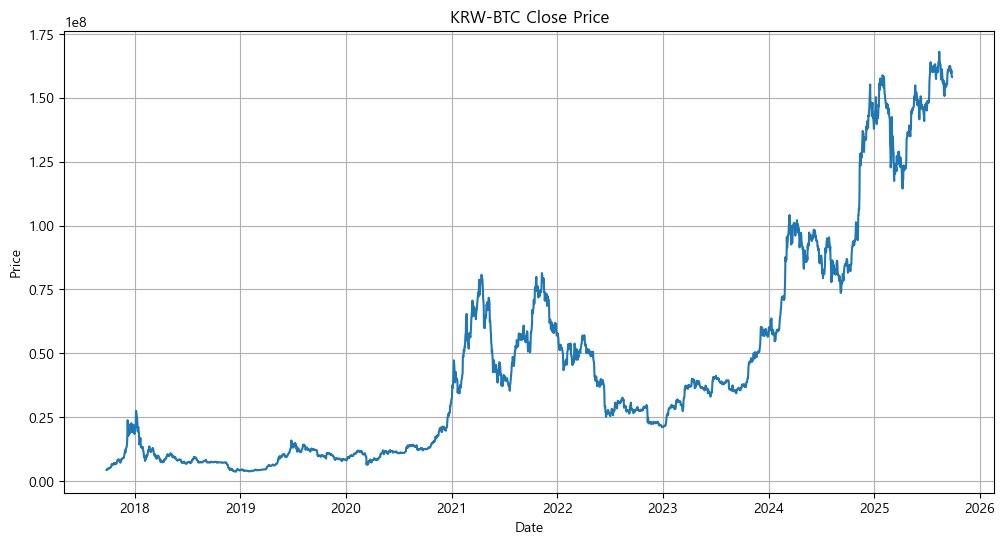

In [10]:
# 종가(close) 가격 시계열 그래프 그리기

plt.figure(figsize=(12,6))
plt.plot(df.index, df['close'])
plt.title(f'{ticker} Close Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.show()

#### -데이터 전처리

##### --결측치 처리
- 데이터 누락 여부 확인 (isnull(), dropna(), fillna())
- 일부 시간대 데이터가 빠질 수 있으니 적절히 보완하거나 제거

In [11]:
# df_clean = df.dropna()

##### --이상치 처리
- 가격이나 거래량 급격한 변동 확인 (예: 가격이 0이거나 음수, 거래량 급감 등)
- 통계적 방법(사분위수, Z-score 등)으로 극단치 탐지 후 처리 또는 제거


In [12]:
# 가격이나 거래량이 0 이하인 이상치 탐색
print("이상치 (가격 또는 거래량이 0 이하) 개수:")
print((df[['open', 'high', 'low', 'close', 'volume', 'value']] <= 0).sum())

이상치 (가격 또는 거래량이 0 이하) 개수:
open      0
high      0
low       0
close     0
volume    0
value     0
dtype: int64


In [13]:
# 가격이 음수거나 0인 행 제거
condition = (df[['open', 'high', 'low', 'close']] > 0).all(axis=1) & (df['volume'] > 0)
df = df[condition]
df

,open,high,low,close,volume,value
2017-09-25 09:00:00,4201000.0,4333000.0,4175000.0,4322000.0,132.484755,5.602146e+08
2017-09-26 09:00:00,4317000.0,4418000.0,4311000.0,4321000.0,22.788340,9.950724e+07
2017-09-27 09:00:00,4322000.0,4677000.0,4318000.0,4657000.0,32.269662,1.448276e+08
2017-09-28 09:00:00,4657000.0,4772000.0,4519000.0,4586000.0,80.588243,3.721860e+08
2017-09-29 09:00:00,4586000.0,4709000.0,4476000.0,4657000.0,59.352373,2.724558e+08
...,...,...,...,...,...,...
2025-09-22 09:00:00,161410000.0,161631000.0,159000000.0,160730000.0,3058.732845,4.896752e+11
2025-09-23 09:00:00,160731000.0,161350000.0,158668000.0,159679000.0,1105.983539,1.770399e+11
2025-09-24 09:00:00,159680000.0,161200000.0,159001000.0,160700000.0,989.636197,1.586071e+11
2025-09-25 09:00:00,160700000.0,161037000.0,158000000.0,158200000.0,2072.657615,3.304437e+11


In [14]:
# 통계적 방법 (IQR)으로 극단치 탐지 예시 - close 기준
Q1 = df['close'].quantile(0.25)
Q3 = df['close'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df['close'] < lower_bound) | (df['close'] > upper_bound)]
print(f"\nClose 가격 IQR 이상치 개수: {len(outliers)}")


Close 가격 IQR 이상치 개수: 224


##### --자료형 변환
- 날짜 인덱스나 컬럼을 datetime 타입으로 변환
- 숫자형 컬럼(open, high, low, close, volume, value)이 정확히 float 또는 int 타입인지 확인 및 변환


In [15]:
# 인덱스가 datetime 형식인지 확인
print(f"인덱스 타입: {type(df.index)}")

# 인덱스가 datetime이 아니라면 변환
if not isinstance(df.index, pd.DatetimeIndex):
    df.index = pd.to_datetime(df.index)
    print("인덱스를 datetime 형식으로 변환 완료")

인덱스 타입: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


In [16]:
# 컬럼별 자료형 확인
print("\n컬럼별 자료형:")
print(df.dtypes)

# 숫자형 컬럼이 float 또는 int가 아니면 변환
num_cols = ['open', 'high', 'low', 'close', 'volume', 'value']
for col in num_cols:
    if not pd.api.types.is_numeric_dtype(df[col]):
        df[col] = pd.to_numeric(df[col], errors='coerce')
        print("인덱스를 float 또는 int 형식으로 변환 완료")


컬럼별 자료형:
open      float64
high      float64
low       float64
close     float64
volume    float64
value     float64
dtype: object


#### -파생 변수 생성
- 이동평균선 (EMA, SMA)
- 기술적 지표 (RSI, MACD, Bollinger Bands 등)
- 거래량 변화율, 수익률 등 전략에 필요한 변수 추가

In [17]:
# 30분봉 데이터 불러오기 (최대 200개 제한 있음)
df = pyupbit.get_ohlcv("KRW-BTC", interval="minute30", count=200)

# 컬럼명 맞추기 (mplfinance는 'Open', 'High' 등 대소문자 구분)
df.rename(columns={ 
    'open': 'Open',
    'high': 'High',
    'low': 'Low',
    'close': 'Close',
    'volume': 'Volume'
}, inplace=True)

In [18]:
# EMA
df['EMA12'] = df['Close'].ewm(span=12).mean()
df['EMA26'] = df['Close'].ewm(span=26).mean()

# MACD
df['MACD'] = df['EMA12'] - df['EMA26']
df['Signal'] = df['MACD'].ewm(span=9).mean()

# RSI
delta = df['Close'].diff()
gain = delta.clip(lower=0).rolling(window=14).mean()
loss = -delta.clip(upper=0).rolling(window=14).mean()
rs = gain / loss
df['RSI'] = 100 - (100 / (1 + rs))

### 3) 시각화

##### -기초 통계

In [19]:
df.describe()

,Open,High,Low,Close,Volume,value,EMA12,EMA26,MACD,Signal,RSI
count,2.000000e+02,2.000000e+02,2.000000e+02,2.000000e+02,200.000000,2.000000e+02,2.000000e+02,2.000000e+02,200.000000,200.000000,186.000000
mean,1.599302e+08,1.601121e+08,1.597260e+08,1.599183e+08,35.562030,5.679804e+09,1.599695e+08,1.600108e+08,-41313.152993,-37255.373083,49.005545
std,7.466084e+05,7.330409e+05,7.581551e+05,7.521835e+05,41.953668,6.699674e+09,6.053447e+05,4.884056e+05,162771.427811,145010.147608,12.879024
min,1.578710e+08,1.579800e+08,1.575880e+08,1.578890e+08,3.064797,4.927528e+08,1.582986e+08,1.585686e+08,-450133.686915,-383841.936842,21.533660
25%,1.595592e+08,1.598338e+08,1.593128e+08,1.595492e+08,15.626142,2.511636e+09,1.598157e+08,1.599221e+08,-142918.389981,-150251.036885,39.479915
50%,1.600075e+08,1.601970e+08,1.598665e+08,1.600155e+08,23.296581,3.723265e+09,1.600413e+08,1.600836e+08,-35998.239519,-39650.943881,48.253167
75%,1.605015e+08,1.606662e+08,1.603418e+08,1.604995e+08,41.583598,6.622711e+09,1.604599e+08,1.603585e+08,101411.097761,91978.129981,59.116269
max,1.610810e+08,1.613500e+08,1.609790e+08,1.610510e+08,468.328869,7.492774e+10,1.607622e+08,1.607583e+08,243625.635842,203961.710180,76.405574


c:\Users\SSAFY\Desktop\project\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\SSAFY\Desktop\project\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 48393 (\N{HANGUL SYLLABLE BONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\SSAFY\Desktop\project\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 52264 (\N{HANGUL SYLLABLE CA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\SSAFY\Desktop\project\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 53944 (\N{HANGUL SYLLABLE TEU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\SSAFY\Desktop\project\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from

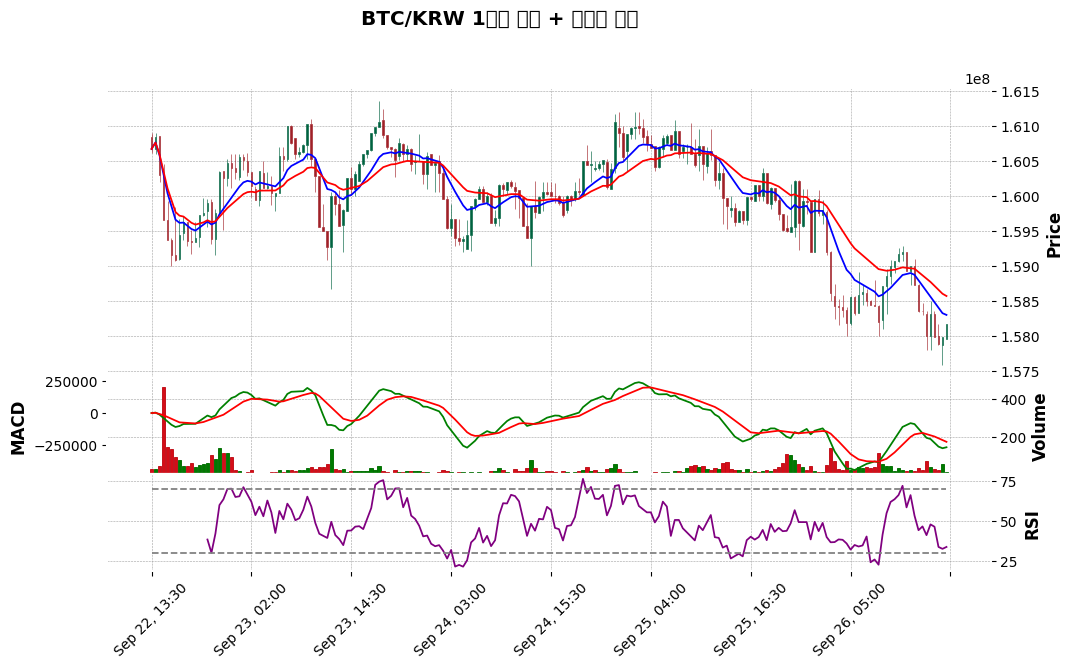

In [20]:
# 가격 + EMA 차트
apds = [
    mpf.make_addplot(df['EMA12'], color='blue'),
    mpf.make_addplot(df['EMA26'], color='red')
]

# MACD subplot
macd_apds = [
    mpf.make_addplot(df['MACD'], panel=1, color='g', ylabel='MACD'),
    mpf.make_addplot(df['Signal'], panel=1, color='r')
]

# RSI subplot + 기준선
rsi_apds = [
    mpf.make_addplot(df['RSI'], panel=2, color='purple', ylabel='RSI'),
    mpf.make_addplot([30]*len(df), panel=2, color='gray', linestyle='--'),
    mpf.make_addplot([70]*len(df), panel=2, color='gray', linestyle='--')
]

# 전체 차트 그리기
mpf.plot(
    df,
    type='candle',           # 캔들차트
    style='charles',
    addplot=apds + macd_apds + rsi_apds,
    volume=True,
    panel_ratios=(6,2,2),    # 가격:MACD:RSI 비율
    figratio=(16,9),
    figscale=1.2,
    title='BTC/KRW 1분봉 차트 + 기술적 지표',
)

MACD 전략 누적 수익률: -2.57%
RSI 전략 누적 수익률: 0.2%
EMA 전략 누적 수익률: -3.06%


C:\Users\SSAFY\AppData\Local\Temp\ipykernel_19632\3259925956.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if not position and buy_signal[i]:
C:\Users\SSAFY\AppData\Local\Temp\ipykernel_19632\3259925956.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif position and sell_signal[i]:
c:\Users\SSAFY\Desktop\project\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 45572 (\N{HANGUL SYLLABLE NU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\SSAFY\Desktop\project\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 49688 (\N{H

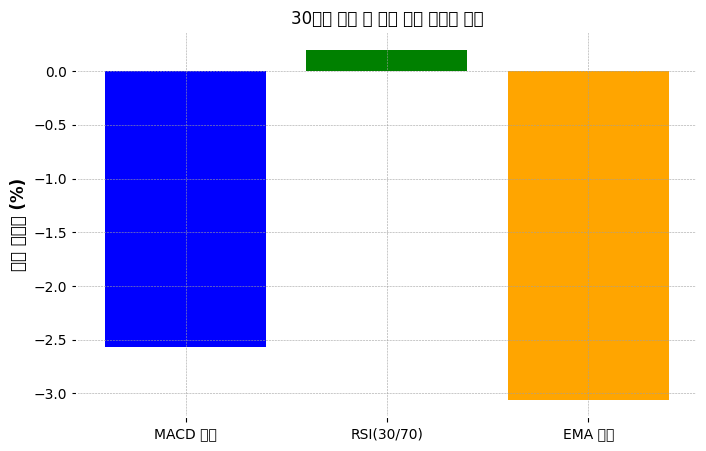

In [21]:
# 공통 백테스트 함수
def simulate_trading(df, buy_signal, sell_signal):
    position = False
    entry_price = 0
    returns = []

    for i in range(1, len(df)):
        if not position and buy_signal[i]:
            entry_price = df['Close'].iloc[i]
            position = True
        elif position and sell_signal[i]:
            exit_price = df['Close'].iloc[i]
            ret = (exit_price - entry_price) / entry_price
            returns.append(ret)
            position = False

    return np.cumprod([1 + r for r in returns])[-1] if returns else 1.0


# 전략 1: MACD 교차
macd_buy = (df['MACD'] > df['Signal']) & (df['MACD'].shift(1) <= df['Signal'].shift(1))
macd_sell = (df['MACD'] < df['Signal']) & (df['MACD'].shift(1) >= df['Signal'].shift(1))
macd_return = simulate_trading(df, macd_buy, macd_sell)

# 전략 2: RSI 기준
rsi_buy = df['RSI'] < 30
rsi_sell = df['RSI'] > 70
rsi_return = simulate_trading(df, rsi_buy, rsi_sell)

# 전략 3: EMA 돌파
ema_buy = (df['Close'] > df['EMA12']) & (df['Close'].shift(1) <= df['EMA12'].shift(1))
ema_sell = (df['Close'] < df['EMA12']) & (df['Close'].shift(1) >= df['EMA12'].shift(1))
ema_return = simulate_trading(df, ema_buy, ema_sell)

# 결과 출력
print(f"MACD 전략 누적 수익률: {round((macd_return - 1) * 100, 2)}%")
print(f"RSI 전략 누적 수익률: {round((rsi_return - 1) * 100, 2)}%")
print(f"EMA 전략 누적 수익률: {round((ema_return - 1) * 100, 2)}%")

# 시각화
strategies = ['MACD 교차', 'RSI(30/70)', 'EMA 돌파']
returns = [macd_return, rsi_return, ema_return]

plt.figure(figsize=(8, 5))
plt.bar(strategies, [(r - 1) * 100 for r in returns], color=['blue', 'green', 'orange'])
plt.ylabel('누적 수익률 (%)')
plt.title('30분봉 기준 각 전략 누적 수익률 비교')
plt.grid(True, axis='y')
plt.show()

In [22]:
# 골든크로스: EMA12가 EMA26을 아래에서 위로 돌파 
# 데드크로스: EMA12가 EMA26을 위에서 아래로 하향 돌파

df['EMA_diff'] = df['EMA12'] - df['EMA26']
df['EMA_cross'] = df['EMA_diff'].apply(lambda x: 1 if x > 0 else -1)

df['cross_signal'] = df['EMA_cross'].diff()

golden_crosses = df[df['cross_signal'] == 2]
dead_crosses = df[df['cross_signal'] == -2]

print("골든크로스 발생 시점:") 
print(golden_crosses.tail())

print("\n데드크로스 발생 시점:") 
print(dead_crosses.tail())

골든크로스 발생 시점:
                            Open         High          Low        Close  \
2025-09-22 14:00:00  160667000.0  160900000.0  160600000.0  160841000.0   
2025-09-22 22:00:00  159755000.0  160349000.0  159724000.0  160345000.0   
2025-09-23 16:00:00  160450000.0  160601000.0  160430000.0  160600000.0   
2025-09-24 19:00:00  160074000.0  160250000.0  160014000.0  160059000.0   

                         Volume         value         EMA12         EMA26  \
2025-09-22 14:00:00   27.412656  4.405065e+09  1.607622e+08  1.607583e+08   
2025-09-22 22:00:00  143.115641  2.291015e+10  1.597347e+08  1.597058e+08   
2025-09-23 16:00:00   18.629026  2.990397e+09  1.601928e+08  1.601743e+08   
2025-09-24 19:00:00   17.142634  2.745684e+09  1.599605e+08  1.599567e+08   

                             MACD        Signal        RSI      EMA_diff  \
2025-09-22 14:00:00   3858.974359   2143.874644        NaN   3858.974359   
2025-09-22 22:00:00  28842.909853 -31543.827902  60.005800  28842.909853 

##### -분포

c:\Users\SSAFY\Desktop\project\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\SSAFY\Desktop\project\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 54252 (\N{HANGUL SYLLABLE PO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


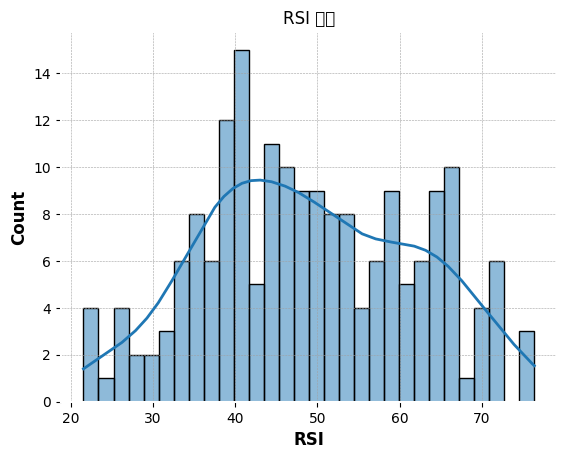

In [23]:
# RSI 분포
sns.histplot(df['RSI'].dropna(), bins=30, kde=True)
plt.title("RSI 분포")
plt.show()

설명	RSI 기술적 지표가 데이터셋 내에서 어떤 값 분포를 가지는지 시각화하는 코드입니다. 이 히스토그램을 통해 RSI가 어떤 구간에 자주 분포하는지 확인할 수 있으며, 과매수/과매도 영역(보통 70 이상 / 30 이하)이 자주 발생하는지도 직관적으로 파악할 수 있습니다.

-> RSI 기반 전략의 유효성 판단을 위해, RSI가 자주 어떤 구간에 위치하는지를 시각적으로 확인할 수 있는 분석입니다.

c:\Users\SSAFY\Desktop\project\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\SSAFY\Desktop\project\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 54252 (\N{HANGUL SYLLABLE PO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\SSAFY\Desktop\project\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 44050 (\N{HANGUL SYLLABLE GABS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


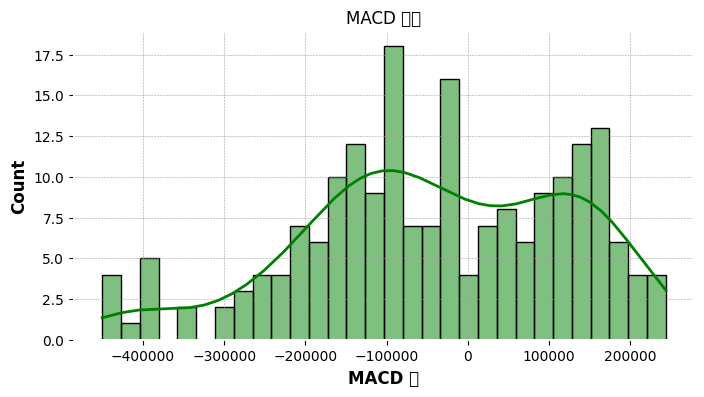

In [24]:
# MACD 분포
plt.figure(figsize=(8,4))
sns.histplot(df['MACD'].dropna(), bins=30, kde=True, color='green')
plt.title("MACD 분포")
plt.xlabel("MACD 값")
plt.show()

MACD (이동 평균 수렴 발산 지표)가 데이터 내에서 어떤 값에 분포되어 있는지 시각적으로 분석합니다. 히스토그램과 KDE 곡선을 통해 MACD 값이 0을 중심으로 대칭적으로 분포하는지, 특정 값에 치우쳐 있는지 확인할 수 있습니다.

-> MACD 기반 전략(MACD가 Signal을 상향 돌파 → 매수 / 하향 돌파 → 매도)이 실효성이 있으려면, MACD가 신호를 자주 낼 수 있는 분포를 가져야 함. 이 분포 시각화는 전략 빈도나 민감도를 판단하는 기반 자료가 됨.

c:\Users\SSAFY\Desktop\project\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 52264 (\N{HANGUL SYLLABLE CA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\SSAFY\Desktop\project\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\SSAFY\Desktop\project\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\SSAFY\Desktop\project\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 54252 (\N{HANGUL SYLLABLE PO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\SSAFY\Desktop\project\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from fo

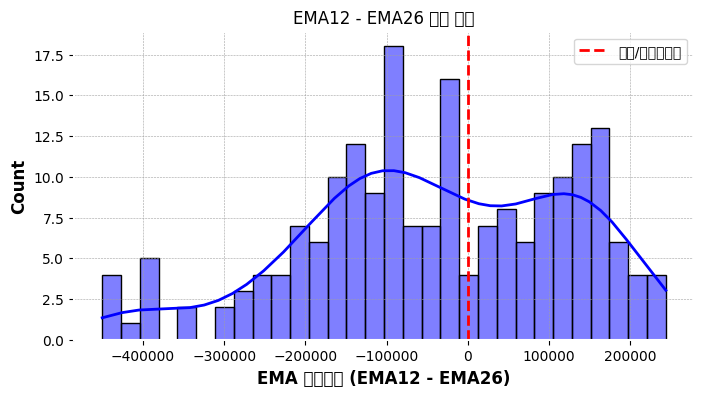

In [25]:
# EMA 차이의 분포

df['EMA_diff'] = df['EMA12'] - df['EMA26']

plt.figure(figsize=(8,4))
sns.histplot(df['EMA_diff'].dropna(), bins=30, kde=True, color='blue')
plt.title("EMA12 - EMA26 차이 분포")
plt.xlabel("EMA 스프레드 (EMA12 - EMA26)")
plt.axvline(0, color='red', linestyle='--', label='골든/데드크로스')
plt.legend()
plt.show()

c:\Users\SSAFY\Desktop\project\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 51068 (\N{HANGUL SYLLABLE IL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\SSAFY\Desktop\project\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 44036 (\N{HANGUL SYLLABLE GAN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\SSAFY\Desktop\project\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\SSAFY\Desktop\project\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 51061 (\N{HANGUL SYLLABLE IG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\SSAFY\Desktop\project\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 47456 (\N{HANGUL SYLLABLE RYUL}) missing from 

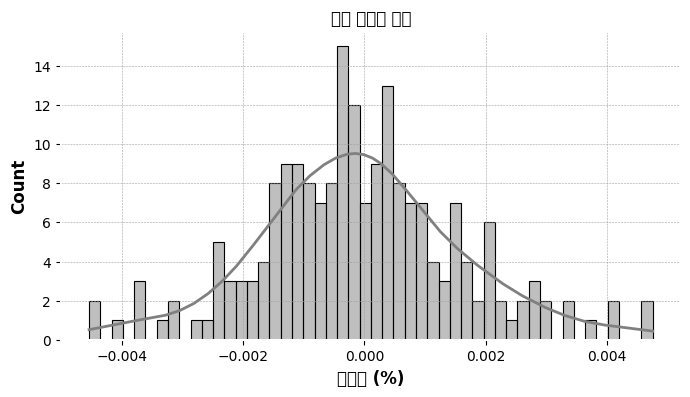

In [26]:
# 일간 수익률 분포
df['return'] = df['Close'].pct_change()

plt.figure(figsize=(8,4))
sns.histplot(df['return'].dropna(), bins=50, kde=True, color='gray')
plt.title("일간 수익률 분포")
plt.xlabel("수익률 (%)")
plt.show()

##### -빈도

In [27]:
def rsi_level(rsi):
    if rsi >= 70:
        return '과매수'
    elif rsi <= 30:
        return '과매도'
    else:
        return '정상'

df['RSI_level'] = df['RSI'].apply(rsi_level)
df['RSI_level'].value_counts()

RSI_level
정상     175
과매수     13
과매도     12
Name: count, dtype: int64

C:\Users\SSAFY\AppData\Local\Temp\ipykernel_19632\2530153795.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='RSI_level', data=df, order=['과매도', '정상', '과매수'], palette='coolwarm')
c:\Users\SSAFY\Desktop\project\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 48712 (\N{HANGUL SYLLABLE BIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\SSAFY\Desktop\project\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\SSAFY\Desktop\project\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\SSAFY\Desktop\pr

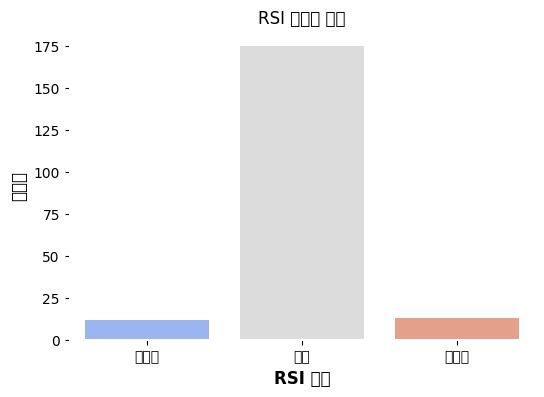

In [28]:
plt.figure(figsize=(6,4))
sns.countplot(x='RSI_level', data=df, order=['과매도', '정상', '과매수'], palette='coolwarm')
plt.title("RSI 구간별 빈도")
plt.xlabel("RSI 상태")
plt.ylabel("빈도수")
plt.grid(axis='y')
plt.show()

In [29]:
# MACD가 양수면 '상승', 음수면 '하락'으로 라벨링
df['MACD_signal'] = df['MACD'].apply(lambda x: '상승' if x > 0 else '하락')

# 각 신호가 얼마나 자주 나타나는지 확인
macd_counts = df['MACD_signal'].value_counts()
print(macd_counts)

MACD_signal
하락    119
상승     81
Name: count, dtype: int64


C:\Users\SSAFY\AppData\Local\Temp\ipykernel_19632\1886923357.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='MACD_signal', data=df, palette='Set2')
c:\Users\SSAFY\Desktop\project\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 48712 (\N{HANGUL SYLLABLE BIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\SSAFY\Desktop\project\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\SSAFY\Desktop\project\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\SSAFY\Desktop\project\venv\Lib\site-packages\I

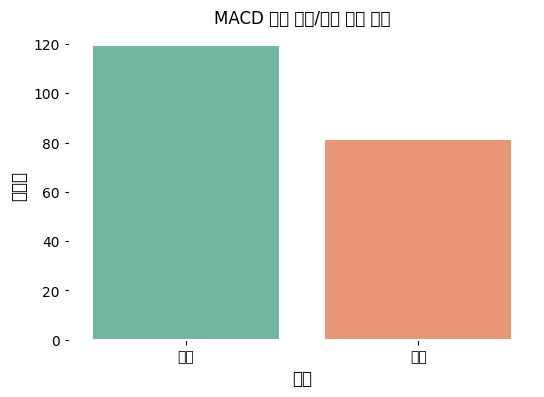

In [30]:
plt.figure(figsize=(6,4))
sns.countplot(x='MACD_signal', data=df, palette='Set2')
plt.title("MACD 기반 상승/하락 신호 빈도")
plt.xlabel("신호")
plt.ylabel("빈도수")
plt.grid(axis='y')
plt.show()

##### -관계

c:\Users\SSAFY\Desktop\project\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\SSAFY\Desktop\project\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 49696 (\N{HANGUL SYLLABLE SUL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\SSAFY\Desktop\project\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\SSAFY\Desktop\project\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 54364 (\N{HANGUL SYLLABLE PYO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\SSAFY\Desktop\project\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 44036 (\N{HANGUL SYLLABLE GAN}) missing from 

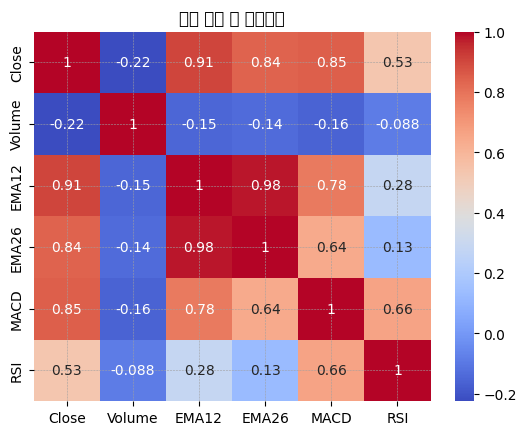

In [31]:
df_corr = df[['Close', 'Volume', 'EMA12', 'EMA26', 'MACD', 'RSI']].corr()
sns.heatmap(df_corr, annot=True, cmap='coolwarm')
plt.title("기술 지표 간 상관관계")
plt.show()

거래량과 가격 변화폭의 상관계수: 0.4804


c:\Users\SSAFY\Desktop\project\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\SSAFY\Desktop\project\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 44201 (\N{HANGUL SYLLABLE GYEOG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\SSAFY\Desktop\project\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 48320 (\N{HANGUL SYLLABLE BYEON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\SSAFY\Desktop\project\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 54868 (\N{HANGUL SYLLABLE HWA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\SSAFY\Desktop\project\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 54253 (\N{HANGUL SYLLABLE POG}) missing 

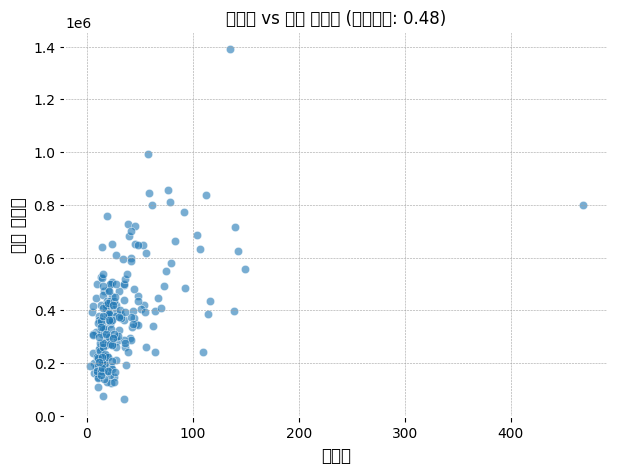

In [32]:
# 가격 변화폭: high - low
df['price_range'] = df['High'] - df['Low']

# 상관계수 계산
corr = df[['Volume', 'price_range']].corr().iloc[0,1]
print(f"거래량과 가격 변화폭의 상관계수: {corr:.4f}")

# 시각화
plt.figure(figsize=(7,5))
sns.scatterplot(x='Volume', y='price_range', data=df, alpha=0.6)
plt.title(f"거래량 vs 가격 변화폭 (상관계수: {corr:.2f})")
plt.xlabel("거래량")
plt.ylabel("가격 변화폭")
plt.show()